In [ ]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
customer = pd.read_csv('customer_join.csv')
uselog_months = pd.read_csv('use_log_months.csv')

In [ ]:
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [ ]:
#membership_period weighs a lot more than other columns so scaling needed
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)
customer_clustering_sc

array([[-0.28120614, -0.13367635,  0.08117747, -0.5336197 ,  2.03402524],
       [-0.14054502, -0.13367635, -0.37992814, -0.02114919,  2.03402524],
       [-0.42186727, -0.13367635, -0.84103375, -0.02114919,  2.03402524],
       ...,
       [ 1.50050144,  1.46662237,  0.08117747,  2.54120338, -1.28811491],
       [ 3.18843493,  3.06692109,  1.46449428,  4.07861492, -1.28811491],
       [ 2.62579043,  2.53348819,  1.00338868,  3.56614441, -1.28811491]])

In [ ]:
# K-means cluster
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit(customer_clustering_sc)

# Make a column 'cluster' from the labels of K-means cluster
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[0 2 3 1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,0
1,5.083333,5.0,7,3,47,0
2,4.583333,5.0,6,3,47,0
3,4.833333,4.5,7,2,47,0
4,3.916667,4.0,6,1,47,0


In [ ]:
customer_clustering.groupby("cluster").count()

,mean,median,max,min,membership_period
cluster,,,,,
0,1239,1239,1239,1239,1239
1,846,846,846,846,846
2,766,766,766,766,766
3,1341,1341,1341,1341,1341


Number of data in descending order: 0 - 2 - 3 -1

In [ ]:
customer_clustering.groupby("cluster").mean()

,mean,median,max,min,membership_period
cluster,,,,,
0,4.674469,4.669492,7.227603,2.149314,37.004843
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,3.058893,2.892950,4.766319,1.651436,9.270235
3,5.523856,5.374720,8.742729,2.691275,14.934377


Looking at the results, cluster 1 has the second highest membership period and max number of usage among customers.

Cluster 2 has the lowest usage of the membership as minimum and maximum number falls very low compared to other clusters.

Cluster 3 has the longest membership period and about average max and min, which could be infered that customers in cluster 3 are the most constant ones to work out.

Cluster 0 has the shortest membership period but has the highest usage of membership as it minimum usage is 6.17 and maximum 10.01. This cluster of customers tend to have worked out the most but somehow they discontinued the membership due to certain reason. Further investigation should be conducted as to why they quit.



In [ ]:
 #Dimensionality reduction
 from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(customer_clustering_sc)
x_pca

array([[-0.81998232, -1.95909657],
       [-0.70792183, -1.79985685],
       [-1.06149902, -1.65982605],
       ...,
       [ 3.02793307,  1.13963534],
       [ 6.08311415,  0.58470806],
       [ 5.06472045,  0.76968382]])

In [ ]:
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]
pca_df

,0,1,cluster
0,-0.819982,-1.959097,0
1,-0.707922,-1.799857,0
2,-1.061499,-1.659826,0
3,-1.160764,-1.810139,0
4,-2.017132,-1.670101,0
...,...,...,...
4187,3.027933,1.139635,1
4188,5.064720,0.769684,1
4189,3.027933,1.139635,1
4190,6.083114,0.584708,1


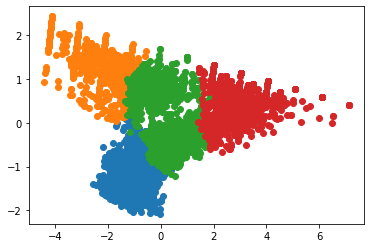

In [ ]:
import matplotlib.pyplot as plt

# scatterplot per cluster
for i in customer_clustering["cluster"].unique():
    tmp = pca_df[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1]) 

In [ ]:
# Finding the portion of discontinued customers in each cluster
# discontinued customers: 'is deleted' =1 

customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,1222
1,0,1,17
2,1,0,827
3,1,1,19
4,2,1,766
5,3,0,793
6,3,1,548


Looking at the result, cluster 0 and 3 have the lowest number of customers who discontinued their membership. Cluster 3 ranked 1st for retaining the highest number of customers by 1230, cluster 0 2nd by 827.
Cluster 1 has  a balanced number of both active and discontinued customers (785, 549). 
Cluster 2 only has discontinued customers (763). 


We can infer that cluster 2 has grouped ex-customers who did not work out as often. Cluster 0 customers are the ones who are excessively enthusiastic (a bit too much) that they ended up quitting as they have shortest membership period. Cluster 3 are the ideal group who have been working out regularly for a long term. Cluster 1 comes in 2nd rank in terms of consistency and length of membership.

In [ ]:
# To see the regularity of membership usage per cluster
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,2
1,0,1,1237
2,1,0,52
3,1,1,794
4,2,0,498
5,2,1,268
6,3,0,227
7,3,1,1114


From this, customers who come on a regular basis tend to extend their membership(cluster 1 and 3) while irregular visits induce membership discontinuation.

**Predicting next month's membership usage rate from the last 6 months data**

In [ ]:
year_months = list(uselog_months["연월"].unique())
predict_data = pd.DataFrame() 
#year_month 6 = 201810, 7 = 201811 ...
for i in range(6, len(year_months)):
    tmp = uselog_months[uselog_months["연월"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)

		# To add previous 6 months data
    for j in range(1, 7):
        tmp_before = uselog_months[uselog_months["연월"]==year_months[i-j]]
        del tmp_before["연월"]
				# Recall the most recent month(201809) as count_0 and the previous months as count_1, count_2 ... count_5
        tmp_before.rename(columns={"count":f"count_{j-1}"}, inplace=True)
				# merge by left join
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")

    predict_data = pd.concat([predict_data, tmp], ignore_index=True)

predict_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [ ]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [ ]:
#Linear regression using data of recent joiners (as customers with long history tend to be repetitive) - from 20180401
predict_data = pd.merge(predict_data, customer, on='customer_id', how='left')
predict_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15113 entries, 0 to 15112
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   연월                 15113 non-null  int64  
 1   customer_id        15113 non-null  object 
 2   count_pred         15113 non-null  int64  
 3   count_0            15113 non-null  float64
 4   count_1            15113 non-null  float64
 5   count_2            15113 non-null  float64
 6   count_3            15113 non-null  float64
 7   count_4            15113 non-null  float64
 8   count_5            15113 non-null  float64
 9   name               15113 non-null  object 
 10  class              15113 non-null  object 
 11  gender             15113 non-null  object 
 12  start_date         15113 non-null  object 
 13  end_date           1437 non-null   object 
 14  campaign_id        15113 non-null  object 
 15  is_deleted         15113 non-null  int64  
 16  class_name         151

In [ ]:
predict_data['start_date'] = predict_data['start_date'].apply(pd.to_datetime)
predict_data = predict_data[predict_data["start_date"]>=pd.to_datetime("20180401")]
predict_data

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,name,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
49,201810,AS185951,1,5.0,3.0,3.0,7.0,3.0,10.0,XXXX,...,1_주간,7500,1_입회비무료,3.800000,3.0,10,1,0,2019-01-31,9
55,201810,AS197200,12,6.0,8.0,9.0,6.0,8.0,8.0,XXXX,...,2_야간,6000,1_입회비무료,8.250000,8.0,12,6,1,2019-04-30,12
56,201810,AS200286,3,6.0,3.0,6.0,6.0,7.0,10.0,XXXX,...,0_종일,10500,1_입회비무료,4.900000,5.0,10,1,1,2019-01-31,9
72,201810,AS251169,2,4.0,6.0,5.0,8.0,10.0,7.0,XXXXX,...,0_종일,10500,1_입회비무료,5.200000,5.0,10,2,1,2019-01-31,9
96,201810,AS345469,1,3.0,5.0,6.0,5.0,4.0,7.0,XXXX,...,1_주간,7500,1_입회비무료,3.666667,3.5,7,1,0,2019-03-31,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15097,201903,TS964483,7,8.0,5.0,6.0,9.0,8.0,8.0,XXXXX,...,0_종일,10500,0_입회비반액할인,7.900000,8.0,11,5,1,2019-04-30,10
15103,201903,TS977703,7,8.0,6.0,7.0,5.0,8.0,8.0,XX,...,0_종일,10500,1_입회비무료,7.000000,7.5,8,4,1,2019-04-30,12
15104,201903,TS978415,7,10.0,7.0,6.0,10.0,8.0,6.0,XXX,...,1_주간,7500,2_일반,8.666667,8.0,14,6,1,2019-04-30,9
15106,201903,TS985617,10,10.0,10.0,9.0,8.0,8.0,9.0,XXXX,...,0_종일,10500,2_일반,9.142857,9.0,10,8,1,2019-04-30,7


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5"]]
y = predict_data["count_pred"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

model = LinearRegression()
model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.6046612632575956
0.6124904792201697


In [ ]:
# To see the contribution
coef = pd.DataFrame({"feature_names":x.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.336967
1,count_1,0.215985
2,count_2,0.145792
3,count_3,0.185181
4,count_4,0.069025
5,count_5,0.049914


The month right before target prediction month makes the most contribution to prediction (count_0)

In [ ]:
#predicting a random customer's next month's number of visit
#x1 visited 7, 8, 6, 4, 4, 3 times over the time frame of 6 months
#x2 visited 6, 4, 3, 3, 2, 2
x1 = [3, 4, 4, 6, 8, 7] 
x2 = [2, 2, 3, 3, 4, 6]
x_pred = [x1, x2]

model.predict(x_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([3.7115377 , 1.91525184])

x1 predicts to visit the center for about 3.71 times for the next month and x2 about 1.89 times. This info helps to make next month's target marketing. 

But based on the analysis we made so far, we have a lot of customers who dropped out fairly quickly within a short period of time, so prediction with previous 6-month data doesn't help. We need to use the last month's data for accuracte prediciton.

**Predicting customer membership resignation**


Note: Resignation notice has to be made at least a month before the targeted resignation month. 
e.g. end_date = 20181130 means this person made a request for resignation on October. So we use the data from September and October only. This is to come up with a retention strategy to find contributing factors to resignation.

In [ ]:
year_months = list(uselog_months["연월"].unique())
print(year_months)

[201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903]


In [ ]:
#anchor data is 201805 as 201804 data doesn't have prior month's data
for i in range(1, len(year_months)):
  print(year_months[i])

201805
201806
201807
201808
201809
201810
201811
201812
201901
201902
201903


In [ ]:
uselog = pd.DataFrame()

for i in range(1, len(year_months)):
    tmp = uselog_months[uselog_months["연월"]==year_months[i]]
    
    #The recent month as 'count_0'
    tmp.rename(columns={"count":"count_0"}, inplace=True)

    # The month before as 'count_1'
    tmp_before = uselog_months[uselog_months["연월"]==year_months[i-1]]
    del tmp_before["연월"]
    tmp_before.rename(columns={"count":"count_1"}, inplace=True)

    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")

    uselog = pd.concat([uselog, tmp], ignore_index=True)
uselog.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연월,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


In [ ]:
# Sort out resigned customer data
exit_customer = customer[customer['is_deleted']==1].reset_index(drop=True)
exit_customer['end_date'] = exit_customer['end_date'].apply(pd.to_datetime)
exit_customer

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,TS511179,XXXXXX,C01,F,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-04-30,23
1,TS443736,XXXX,C02,M,2016-05-01,2018-04-30,CA1,1,1_주간,7500,2_일반,3.0,3.0,3,3,0,2018-04-30,23
2,HD542886,XX,C01,M,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,1.0,1.0,1,1,0,2018-04-30,23
3,HD597545,XXXXX,C03,F,2016-06-01,2018-05-31,CA1,1,2_야간,6000,2_일반,3.5,3.5,4,3,1,2018-05-31,23
4,HI749296,XXXXX,C01,M,2016-06-01,2018-05-31,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-05-31,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,OA143589,XXXXX,C03,F,2019-01-15,2019-02-28,CA1,1,2_야간,6000,2_일반,4.5,4.5,6,3,0,2019-02-28,1
1346,GD367382,XXXX,C01,M,2019-01-15,2019-03-31,CA1,1,0_종일,10500,2_일반,7.0,6.0,12,3,0,2019-03-31,2
1347,OA034442,XXXXX,C02,M,2019-02-05,2019-03-31,CA1,1,1_주간,7500,2_일반,7.0,7.0,11,3,0,2019-03-31,1
1348,PL508278,XXXXX,C03,M,2019-02-09,2019-03-31,CA1,1,2_야간,6000,2_일반,7.0,7.0,10,4,0,2019-03-31,1


In [ ]:
from dateutil.relativedelta import relativedelta
exit_customer["exit_date"] = 0

# Retreiving the month before data from the resignation month
for i in range(len(exit_customer)):
  exit_customer["exit_date"][i] = exit_customer["end_date"][i] - relativedelta(months=1)

# exit_date 에 있는 값에서 연, 월만 추출해서 연월이라는 열로 저장
exit_customer["연월"] = pd.to_datetime(exit_customer["exit_date"]).dt.strftime("%Y%m")
exit_customer.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,연월
0,TS511179,XXXXXX,C01,F,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-04-30,23,2018-03-30 00:00:00,201803
1,TS443736,XXXX,C02,M,2016-05-01,2018-04-30,CA1,1,1_주간,7500,2_일반,3.0,3.0,3,3,0,2018-04-30,23,2018-03-30 00:00:00,201803
2,HD542886,XX,C01,M,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,1.0,1.0,1,1,0,2018-04-30,23,2018-03-30 00:00:00,201803
3,HD597545,XXXXX,C03,F,2016-06-01,2018-05-31,CA1,1,2_야간,6000,2_일반,3.5,3.5,4,3,1,2018-05-31,23,2018-04-30 00:00:00,201804
4,HI749296,XXXXX,C01,M,2016-06-01,2018-05-31,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-05-31,23,2018-04-30 00:00:00,201804


In [ ]:
# merge uselog and exit_customer. Anchor=uselog
#uselong '연월' is in integer form so change it to string form
uselog["연월"] = uselog["연월"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id", "연월"], how="left")
exit_uselog.head()

,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Delete the null data which are non-targeted months data
exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

1104
1104


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,2_일반,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,2_일반,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,2_일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,2_일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,2_일반,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


In [ ]:
# Sort out present customer data
present_customer = customer[customer["is_deleted"]==0]

# uselog 데이터와 결합
present_uselog = pd.merge(uselog, present_customer, on=["customer_id"], how="left")

# 결측값 제거
present_uselog = present_uselog.dropna(subset=["name"])
print(len(present_uselog))

27422


In [ ]:
present_uselog

,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201805,AS002855,5,4.0,XXXX,C03,F,2016-11-01,NaN,CA1,...,2_야간,6000.0,2_일반,4.500000,5.0,7.0,2.0,1.0,2019-04-30,29.0
1,201805,AS009373,4,3.0,XX,C01,F,2015-11-01,NaN,CA1,...,0_종일,10500.0,2_일반,5.083333,5.0,7.0,3.0,1.0,2019-04-30,41.0
2,201805,AS015233,7,NaN,XXXXX,C01,M,2018-05-13,NaN,CA2,...,0_종일,10500.0,0_입회비반액할인,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0
3,201805,AS015315,3,6.0,XXXXX,C01,M,2015-07-01,NaN,CA1,...,0_종일,10500.0,2_일반,4.833333,5.0,7.0,3.0,1.0,2019-04-30,45.0
4,201805,AS015739,5,7.0,XXXXX,C03,M,2017-06-01,NaN,CA1,...,2_야간,6000.0,2_일반,5.583333,5.5,8.0,4.0,1.0,2019-04-30,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33846,201903,TS995853,8,11.0,XXXX,C01,M,2019-02-08,NaN,CA1,...,0_종일,10500.0,2_일반,9.500000,9.5,11.0,8.0,1.0,2019-04-30,2.0
33847,201903,TS998593,8,7.0,XXXXX,C03,M,2018-09-01,NaN,CA1,...,2_야간,6000.0,2_일반,8.142857,8.0,9.0,7.0,1.0,2019-04-30,7.0
33848,201903,TS999079,3,2.0,XXX,C03,M,2016-06-01,NaN,CA1,...,2_야간,6000.0,2_일반,4.916667,5.5,9.0,2.0,1.0,2019-04-30,34.0
33849,201903,TS999231,6,6.0,XXXX,C01,M,2017-03-01,NaN,CA1,...,0_종일,10500.0,2_일반,4.666667,5.0,8.0,1.0,1.0,2019-04-30,25.0


In [ ]:
#'present_uselog' dataframe is in ascending months order. Mix the data randomly to prevent certain month's data abusing the result before deleting some index to match the resigned customer data length.
present_uselog = present_uselog.sample(frac=1).reset_index(drop=True)
#frac=1 means mixing all data. Frac=0.5 means mixing half of the data

# customer_id 기준으로 중복을 제거하고 한 샘플만 남긴다.
present_uselog = present_uselog.drop_duplicates(subset="customer_id")
print(len(present_uselog))
present_uselog.head()



2842


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201811,AS933597,5,2.0,XXXX,C01,M,2015-07-01,NaN,CA1,...,0_종일,10500.0,2_일반,3.916667,3.5,8.0,1.0,1.0,2019-04-30,45.0
1,201808,HI488259,6,5.0,XXXX,C02,F,2017-01-01,NaN,CA1,...,1_주간,7500.0,2_일반,5.750000,6.0,8.0,3.0,1.0,2019-04-30,27.0
2,201809,AS516140,3,6.0,XX,C02,F,2016-03-01,NaN,CA1,...,1_주간,7500.0,2_일반,5.000000,5.5,7.0,3.0,1.0,2019-04-30,37.0
3,201811,HI154843,8,8.0,XX,C03,M,2018-06-05,NaN,CA2,...,2_야간,6000.0,0_입회비반액할인,7.300000,8.0,10.0,4.0,1.0,2019-04-30,10.0
4,201807,PL839656,5,5.0,XXXXX,C01,F,2017-02-01,NaN,CA1,...,0_종일,10500.0,2_일반,5.666667,5.5,8.0,2.0,1.0,2019-04-30,26.0


In [ ]:
# Merge the resigned customer and present customer data
predict_data = pd.concat([present_uselog, exit_uselog], ignore_index=True)
print(len(predict_data))
predict_data

3946


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201811,AS933597,5,2.0,XXXX,C01,M,2015-07-01,NaN,CA1,...,10500.0,2_일반,3.916667,3.5,8.0,1.0,1.0,2019-04-30,45.0,NaN
1,201808,HI488259,6,5.0,XXXX,C02,F,2017-01-01,NaN,CA1,...,7500.0,2_일반,5.750000,6.0,8.0,3.0,1.0,2019-04-30,27.0,NaN
2,201809,AS516140,3,6.0,XX,C02,F,2016-03-01,NaN,CA1,...,7500.0,2_일반,5.000000,5.5,7.0,3.0,1.0,2019-04-30,37.0,NaN
3,201811,HI154843,8,8.0,XX,C03,M,2018-06-05,NaN,CA2,...,6000.0,0_입회비반액할인,7.300000,8.0,10.0,4.0,1.0,2019-04-30,10.0,NaN
4,201807,PL839656,5,5.0,XXXXX,C01,F,2017-02-01,NaN,CA1,...,10500.0,2_일반,5.666667,5.5,8.0,2.0,1.0,2019-04-30,26.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,201902,TS645212,4,2.0,XXXX,C03,F,2018-03-01,2019-03-31 00:00:00,CA1,...,6000.0,2_일반,4.500000,4.5,7.0,1.0,0.0,2019-03-31,12.0,2019-02-28 00:00:00
3942,201902,TS741703,5,6.0,XXXX,C03,M,2018-12-08,2019-03-31 00:00:00,CA3,...,6000.0,1_입회비무료,6.250000,6.0,8.0,5.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00
3943,201902,TS859258,1,3.0,XXXXX,C02,F,2018-12-07,2019-03-31 00:00:00,CA3,...,7500.0,1_입회비무료,2.500000,2.0,5.0,1.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00
3944,201902,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31 00:00:00,CA1,...,7500.0,2_일반,4.250000,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28 00:00:00


In [ ]:
predict_data.isnull().sum()

연월                      0
customer_id             0
count_0                 0
count_1               254
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
dtype: int64

In [ ]:
#Delete the ex customer data with less than 2 months of history -> NA in 'count_1' means the ones w/ less than 2 months of history
predict_data = predict_data.dropna(subset=["count_1"])
predict_data.isnull().sum()

연월                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2640
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2640
dtype: int64

**Predicting with decision tree model**

In [ ]:
target_col = ["campaign_name", "class_name", "gender", "count_0", "count_1", "routine_flg", "is_deleted"]
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_0,count_1,routine_flg,is_deleted
0,2_일반,0_종일,M,5,2.0,1.0,0.0
1,2_일반,1_주간,F,6,5.0,1.0,0.0
2,2_일반,1_주간,F,3,6.0,1.0,0.0
3,0_입회비반액할인,2_야간,M,8,8.0,1.0,0.0
4,2_일반,0_종일,F,5,5.0,1.0,0.0


In [ ]:
#Change categorical data to dummmie data
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_0,count_1,routine_flg,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,campaign_name_2_일반,class_name_0_종일,class_name_1_주간,class_name_2_야간,gender_F,gender_M
0,5,2.0,1.0,0.0,0,0,1,1,0,0,0,1
1,6,5.0,1.0,0.0,0,0,1,0,1,0,1,0
2,3,6.0,1.0,0.0,0,0,1,0,1,0,1,0
3,8,8.0,1.0,0.0,1,0,0,0,0,1,0,1
4,5,5.0,1.0,0.0,0,0,1,1,0,0,1,0


In [ ]:
#Delete unnecessary columns as they are repetitive
del predict_data["campaign_name_2_일반"]
del predict_data["class_name_2_야간"]
del predict_data["gender_M"]
predict_data.head()

,count_0,count_1,routine_flg,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,class_name_0_종일,class_name_1_주간,gender_F
0,5,2.0,1.0,0.0,0,0,1,0,0
1,6,5.0,1.0,0.0,0,0,0,1,1
2,3,6.0,1.0,0.0,0,0,0,1,1
3,8,8.0,1.0,0.0,1,0,0,0,0
4,5,5.0,1.0,0.0,0,0,1,0,1


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
discontinued = predict_data[predict_data["is_deleted"]==1]
len(exit)

1052

In [ ]:
present = predict_data[predict_data["is_deleted"]==0]
len(conti)

2640

In [ ]:
#need to fit the amount of present data to disconinued data to reduce bias
present.sample(1052)

,count_0,count_1,routine_flg,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,class_name_0_종일,class_name_1_주간,gender_F
2264,5,4.0,1.0,0.0,0,0,0,0,0
2595,3,5.0,1.0,0.0,0,0,0,0,1
2355,9,6.0,1.0,0.0,0,0,1,0,0
583,5,4.0,1.0,0.0,0,0,0,0,0
2176,5,6.0,1.0,0.0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
2562,5,6.0,1.0,0.0,0,0,0,1,1
2266,4,8.0,1.0,0.0,0,0,1,0,1
2820,9,10.0,1.0,0.0,0,0,0,1,1
339,4,5.0,1.0,0.0,0,0,0,1,1


In [ ]:
x = pd.concat([discontinued, present], ignore_index=True)

# Retreive 'is_deleted' as y
y = x["is_deleted"]
del x["is_deleted"]

x_train, x_test, y_train, y_test = train_test_split(x, y)

# Decision tree
model = DecisionTreeClassifier(random_state=0)
model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.9389671361502347
0.8905742145178764


Train data overfits so shallow the depth of tree model

In [ ]:
x = pd.concat([exit, conti], ignore_index=True)
y = x["is_deleted"]
del x["is_deleted"]
x_train, x_test, y_train, y_test = train_test_split(x, y)

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.8985193210545324
0.905742145178765


See the overfitting problem has been solved as the difference between train data and test data results are smaller.

In [ ]:
#Check the contribution for each factor
contribution = pd.DataFrame({"feature_names":x.columns, "coefficient":model.feature_importances_})
contribution

,feature_names,coefficient
0,count_0,0.253367
1,count_1,0.086470
2,routine_flg,0.566023
3,campaign_name_0_입회비반액할인,0.037279
4,campaign_name_1_입회비무료,0.056609
5,class_name_0_종일,0.000252
6,class_name_1_주간,0.000000
7,gender_F,0.000000


Unlike Logistic regression, we can get the coefficient from  model.features_importance_ . Looks like 'count_0' which is the last month's usage, routine_flg which is the regularity of visits  mostly plays an important role in this decision tree model. 

In [ ]:
# random data of a customer
count_0 = 4
count_1 = 3
routine_flg = 1
campaign_name_0 = 0
campaign_name_1 = 1 # registration fee waived
class_name_0 = 1 #all day member
class_name_1 = 0
gender_F = 1

In [ ]:
random = [count_0, count_1, routine_flg, campaign_name_0, campaign_name_1, class_name_0, class_name_1, gender_F]

In [ ]:
print(model.predict([random]))

[1.]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


predict = 1 means 'is_deleted' = 1 . This user is a discontinued customer. 

In [ ]:
#To improve the decision tree model accuracy rate, recall customer retention period info
predict_data = pd.concat([present_uselog, exit_uselog], ignore_index=True)
predict_data

,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201811,AS933597,5,2.0,XXXX,C01,M,2015-07-01,NaN,CA1,...,10500.0,2_일반,3.916667,3.5,8.0,1.0,1.0,2019-04-30,45.0,NaN
1,201808,HI488259,6,5.0,XXXX,C02,F,2017-01-01,NaN,CA1,...,7500.0,2_일반,5.750000,6.0,8.0,3.0,1.0,2019-04-30,27.0,NaN
2,201809,AS516140,3,6.0,XX,C02,F,2016-03-01,NaN,CA1,...,7500.0,2_일반,5.000000,5.5,7.0,3.0,1.0,2019-04-30,37.0,NaN
3,201811,HI154843,8,8.0,XX,C03,M,2018-06-05,NaN,CA2,...,6000.0,0_입회비반액할인,7.300000,8.0,10.0,4.0,1.0,2019-04-30,10.0,NaN
4,201807,PL839656,5,5.0,XXXXX,C01,F,2017-02-01,NaN,CA1,...,10500.0,2_일반,5.666667,5.5,8.0,2.0,1.0,2019-04-30,26.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,201902,TS645212,4,2.0,XXXX,C03,F,2018-03-01,2019-03-31 00:00:00,CA1,...,6000.0,2_일반,4.500000,4.5,7.0,1.0,0.0,2019-03-31,12.0,2019-02-28 00:00:00
3942,201902,TS741703,5,6.0,XXXX,C03,M,2018-12-08,2019-03-31 00:00:00,CA3,...,6000.0,1_입회비무료,6.250000,6.0,8.0,5.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00
3943,201902,TS859258,1,3.0,XXXXX,C02,F,2018-12-07,2019-03-31 00:00:00,CA3,...,7500.0,1_입회비무료,2.500000,2.0,5.0,1.0,0.0,2019-03-31,3.0,2019-02-28 00:00:00
3944,201902,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31 00:00:00,CA1,...,7500.0,2_일반,4.250000,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28 00:00:00


In [ ]:
from dateutil.relativedelta import relativedelta

predict_data["period"] = 0

#Add new column 'current_date'
predict_data["current_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")

# Change 'start_date' to datetime type
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

for i in range(len(predict_data)):
    delta = relativedelta(predict_data["current_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = int(delta.years*12 + delta.months)

predict_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,current_date
0,201811,AS933597,5,2.0,XXXX,C01,M,2015-07-01,NaN,CA1,...,3.916667,3.5,8.0,1.0,1.0,2019-04-30,45.0,NaN,40,2018-11-01
1,201808,HI488259,6,5.0,XXXX,C02,F,2017-01-01,NaN,CA1,...,5.750000,6.0,8.0,3.0,1.0,2019-04-30,27.0,NaN,19,2018-08-01
2,201809,AS516140,3,6.0,XX,C02,F,2016-03-01,NaN,CA1,...,5.000000,5.5,7.0,3.0,1.0,2019-04-30,37.0,NaN,30,2018-09-01
3,201811,HI154843,8,8.0,XX,C03,M,2018-06-05,NaN,CA2,...,7.300000,8.0,10.0,4.0,1.0,2019-04-30,10.0,NaN,4,2018-11-01
4,201807,PL839656,5,5.0,XXXXX,C01,F,2017-02-01,NaN,CA1,...,5.666667,5.5,8.0,2.0,1.0,2019-04-30,26.0,NaN,17,2018-07-01


In [ ]:
# Add a new column 'period' to decision tree model 'x'
predict_data = predict_data.dropna(subset=["count_1"])

target_col = ["campaign_name", "class_name", "gender", "count_0", "count_1", "period", "routine_flg", "is_deleted"]
predict_data = predict_data[target_col]

predict_data = pd.get_dummies(predict_data)
predict_data

del predict_data["campaign_name_2_일반"]
del predict_data["class_name_2_야간"]
del predict_data["gender_M"]

conti = predict_data[predict_data['is_deleted']==0].sample(1052)
exit = predict_data[predict_data['is_deleted']==1]

In [ ]:
x = pd.concat([exit, conti], ignore_index=True)
y = x["is_deleted"]
del x["is_deleted"]
x_train, x_test, y_train, y_test = train_test_split(x, y)

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(x_train, y_train)
print(model.score(x_test, y_test))
print(model.score(x_train, y_train))

0.9543726235741445
0.9569074778200254


Adding another column shows that it has increased the prediction accuracy very well.

In [ ]:
# Evaluating decision tree prediction performance
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def metrics(y_test, pred):
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  print(f'accuracy : {accuracy:.4f}, precision : {precision:.4f}, recall: {precision:.4f}')
  print(f'f1-score : {f1:.4f}')

In [ ]:
model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

accuracy : 0.9544, precision : 0.9470, recall: 0.9470
f1-score : 0.9542


All metrics are high enough for the decision tree prediction model to be credible, especially accuracy and f1 score doesnt have much difference because we manually sampled the same amount of data among present customers and discontinued customers. We can say the labels initially were stable. 

In [ ]:
#Compare prediction capability with Logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

accuracy : 0.9677, precision : 0.9655, recall: 0.9655
f1-score : 0.9674


From this, we could tell Logistic regression model brings better result for all metrics of prediction performance than using Decision Tree model.